### Goals
In this notebook, you're going to implement a U-Net for a biomedical imaging segmentation task. Specifically, you're going to be labeling neurons, so one might call this a neural neural network! ;) 

Note that this is not a GAN, generative model, or unsupervised learning task. This is a supervised learning task, so there's only one correct answer (like a classifier!) You will see how this component underlies the Generator component of Pix2Pix in the next notebook this week.

### Learning Objectives
1.   Implement your own U-Net.
2.   Observe your U-Net's performance on a challenging segmentation task.


In [1]:
import sys, torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
sys.path.append("..")

from models.UNET.unet import ContractingBlock, ExpandingBlock, UpsamplingBlock, UNet
from models.vis_utils import show_img_batch
from models.utils import crop
%matplotlib inline

device = "mps" if torch.backends.mps.is_available() else "cpu"

In [2]:
hidden_size        = 64
sample             = torch.randn(10, 1, 572, 572)

### Contracting network
print("--------------- Contracting network ---------------")
contracting_block1 = ContractingBlock(1,               hidden_size)
contracting_block2 = ContractingBlock(hidden_size * 1, hidden_size * 2)
contracting_block3 = ContractingBlock(hidden_size * 2, hidden_size * 4)
contracting_block4 = ContractingBlock(hidden_size * 4, hidden_size * 8)
contracting_block5 = ContractingBlock(hidden_size * 8, hidden_size * 16)
cb1  = contracting_block1(sample)
print("cb1  shape: ", cb1.shape) 
cb1_ = nn.MaxPool2d(kernel_size=2, stride=2)(cb1)
print("cb1_ shape: ", cb1_.shape) 
cb2 = contracting_block2(cb1_)
print("cb2  shape: ", cb2.shape) 
cb2_ = nn.MaxPool2d(kernel_size=2, stride=2)(cb2)
print("cb2_ shape: ", cb2_.shape) 
cb3 = contracting_block3(cb2_)
print("cb3  shape: ", cb3.shape)
cb3_ = nn.MaxPool2d(kernel_size=2, stride=2)(cb3)
print("cb3_ shape: ", cb3_.shape)
cb4 = contracting_block4(cb3_)
print("cb4  shape: ", cb4.shape)
cb4_ = nn.MaxPool2d(kernel_size=2, stride=2)(cb4)
print("cb4_ shape: ", cb4_.shape)
cb5 = contracting_block5(cb4_)
print("cb5  shape: ", cb5.shape)

### Expanding network
print("---------------- Expanding network ----------------")
expanding_block5 = ExpandingBlock(hidden_size * 16, hidden_size * 8)
expanding_block4 = ExpandingBlock(hidden_size * 8,  hidden_size * 4)
expanding_block3 = ExpandingBlock(hidden_size * 4,  hidden_size * 2)
expanding_block2 = ExpandingBlock(hidden_size * 2,  hidden_size * 1)

eb5 = UpsamplingBlock(hidden_size*16, hidden_size*8)(cb5)
print("eb5  shape: ", eb5.shape) 
eb4 = expanding_block5(eb5, cb4)
print("eb4  shape: ", eb4.shape) 
eb4_ = UpsamplingBlock(hidden_size*8, hidden_size*4)(eb4)
print("eb4_ shape: ", eb4_.shape) 
eb3 = expanding_block4(eb4_, cb3)
print("eb3  shape: ", eb3.shape)
eb3_ = UpsamplingBlock(hidden_size*4, hidden_size*2)(eb3)
print("eb3_ shape: ", eb3_.shape) 
eb2 = expanding_block3(eb3_, cb2)
print("eb2 shape: ", eb2.shape)
eb2_ = UpsamplingBlock(hidden_size*2, hidden_size*1)(eb2)
print("eb2_ shape: ", eb2_.shape) 
eb1 = expanding_block2(eb2_, cb1)
print("eb1 shape: ", eb1.shape)
eb0 = nn.Conv2d(hidden_size,1, kernel_size=1)(eb1)
print("eb0 shape: ", eb0.shape)

--------------- Contracting network ---------------
cb1  shape:  torch.Size([10, 64, 568, 568])
cb1_ shape:  torch.Size([10, 64, 284, 284])
cb2  shape:  torch.Size([10, 128, 280, 280])
cb2_ shape:  torch.Size([10, 128, 140, 140])
cb3  shape:  torch.Size([10, 256, 136, 136])
cb3_ shape:  torch.Size([10, 256, 68, 68])
cb4  shape:  torch.Size([10, 512, 64, 64])
cb4_ shape:  torch.Size([10, 512, 32, 32])
cb5  shape:  torch.Size([10, 1024, 28, 28])
---------------- Expanding network ----------------
eb5  shape:  torch.Size([10, 512, 56, 56])
eb4  shape:  torch.Size([10, 512, 52, 52])
eb4_ shape:  torch.Size([10, 256, 104, 104])
eb3  shape:  torch.Size([10, 256, 100, 100])
eb3_ shape:  torch.Size([10, 128, 200, 200])
eb2 shape:  torch.Size([10, 128, 196, 196])
eb2_ shape:  torch.Size([10, 64, 392, 392])
eb1 shape:  torch.Size([10, 64, 388, 388])
eb0 shape:  torch.Size([10, 1, 388, 388])


In [3]:
sample = torch.randn(10, 1, 572, 572)
unet = UNet(1,1,64)
u_sample = unet(sample)
print(f"Input shape is {sample.shape} | Output shape is {u_sample.shape}")

Input shape is torch.Size([10, 1, 572, 572]) | Output shape is torch.Size([10, 1, 388, 388])


## Training a Unet model

In [4]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
input_dim = 1
label_dim = 1
display_step = 100
hidden_size = 64
batch_size = 4
lr = 0.0002
initial_shape = 512
target_shape = 324
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [6]:
from skimage import io
import numpy as np
volumes = torch.Tensor(io.imread('../datasets/unet/train-volume.tif'))[:, None, :, :] / 255
labels = torch.Tensor(io.imread('../datasets/unet/train-labels.tif', plugin="tifffile"))[:, None, :, :] / 255
labels = crop(labels, (target_shape, target_shape))
dataset = torch.utils.data.TensorDataset(volumes, labels)

 25%|██▌       | 2/8 [00:01<00:03,  1.73it/s]

Epoch 0: Step 0: U-Net loss: 0.6823418140411377


 75%|███████▌  | 6/8 [00:03<00:01,  1.80it/s]

Epoch 12: Step 100: U-Net loss: 0.35348814725875854


 25%|██▌       | 2/8 [00:01<00:02,  2.22it/s]

Epoch 25: Step 200: U-Net loss: 0.3301825225353241


 75%|███████▌  | 6/8 [00:03<00:01,  1.81it/s]

Epoch 37: Step 300: U-Net loss: 0.3198344111442566


 25%|██▌       | 2/8 [00:01<00:02,  2.21it/s]

Epoch 50: Step 400: U-Net loss: 0.242649644613266


 75%|███████▌  | 6/8 [00:03<00:01,  1.82it/s]

Epoch 62: Step 500: U-Net loss: 0.18623393774032593


 25%|██▌       | 2/8 [00:01<00:02,  2.22it/s]

Epoch 75: Step 600: U-Net loss: 0.13935227692127228


 75%|███████▌  | 6/8 [00:03<00:01,  1.81it/s]

Epoch 87: Step 700: U-Net loss: 0.10884220898151398


 25%|██▌       | 2/8 [00:01<00:02,  2.22it/s]

Epoch 100: Step 800: U-Net loss: 0.09037284553050995


 75%|███████▌  | 6/8 [00:03<00:01,  1.82it/s]

Epoch 112: Step 900: U-Net loss: 0.06970656663179398


 25%|██▌       | 2/8 [00:01<00:02,  2.22it/s]

Epoch 125: Step 1000: U-Net loss: 0.05800898000597954


 75%|███████▌  | 6/8 [00:03<00:01,  1.81it/s]

Epoch 137: Step 1100: U-Net loss: 0.04745139554142952


 25%|██▌       | 2/8 [00:01<00:02,  2.22it/s]

Epoch 150: Step 1200: U-Net loss: 0.039295781403779984


 75%|███████▌  | 6/8 [00:03<00:01,  1.81it/s]

Epoch 162: Step 1300: U-Net loss: 0.0343315564095974


 25%|██▌       | 2/8 [00:01<00:02,  2.22it/s]

Epoch 175: Step 1400: U-Net loss: 0.034979552030563354


 75%|███████▌  | 6/8 [00:03<00:01,  1.81it/s]

Epoch 187: Step 1500: U-Net loss: 0.02156314067542553


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


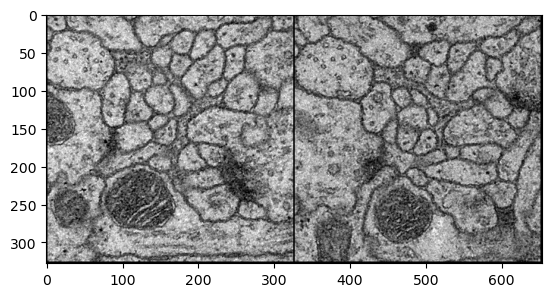

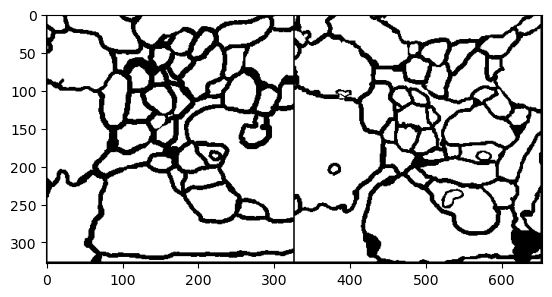

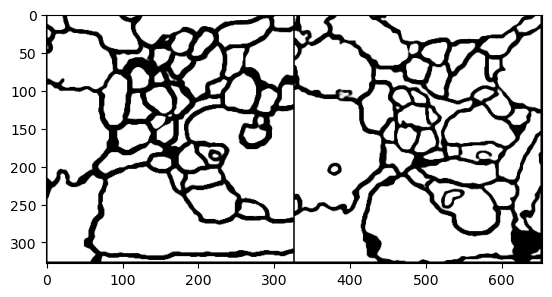

In [7]:
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True)
unet = UNet(input_dim, label_dim, hidden_size).to(device)
unet_opt = torch.optim.Adam(unet.parameters(), lr=lr)
cur_step = 0

for epoch in range(n_epochs):
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        labels = labels.to(device)

        ### Update U-Net ###
        unet_opt.zero_grad()
        pred = unet(real)
        unet_loss = criterion(pred, labels)
        unet_loss.backward()
        unet_opt.step()

        if cur_step % display_step == 0:
            print(f"Epoch {epoch}: Step {cur_step}: U-Net loss: {unet_loss.item()}")
        #     show_img_batch(crop(real, torch.Size([target_shape, target_shape])), 
        #                    size=(input_dim, target_shape, target_shape))
        #     show_img_batch(labels, size=(label_dim, target_shape, target_shape))
        #     show_img_batch(torch.sigmoid(pred), size=(label_dim, target_shape, target_shape))
        cur_step += 1
show_img_batch(crop(real, torch.Size([target_shape, target_shape])), 
               size=(input_dim, target_shape, target_shape))
show_img_batch(labels, size=(label_dim, target_shape, target_shape))
show_img_batch(torch.sigmoid(pred), size=(label_dim, target_shape, target_shape))
